In [1]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [2]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print(os.listdir('../input/shopee-sentiment-analysis'))

/kaggle/input/shopee-sentiment-analysis/train.csv
/kaggle/input/shopee-sentiment-analysis/sampleSubmission.csv
/kaggle/input/shopee-sentiment-analysis/test.csv
['train.csv', 'sampleSubmission.csv', 'test.csv']


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

from tqdm import tqdm

In [4]:
from keras.utils import to_categorical
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

tf.random.set_seed(123)

In [5]:
train = pd.read_csv('../input/shopee-sentiment-analysis/train.csv')
test = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')

print(train.head())
train.shape

   review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1


(146811, 3)

In [6]:
print(test.head())
test.shape

   review_id                                             review
0          1  Great danger, cool, motif and cantik2 jg model...
1          2                   One of the shades don't fit well
2          3                                   Very comfortable
3          4  Fast delivery. Product expiry is on Dec 2022. ...
4          5  it's sooooo cute! i like playing with the glit...


(60427, 2)

# # # Create Function, remove non-alphabetic characters, and tokenize the sentences****

In [7]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['review']):        
        review_text = BeautifulSoup(sent).get_text()        
        review_text = re.sub("[^a-zA-Z]"," ", review_text)    
        words = word_tokenize(review_text.lower())    
        lemma_words = [lemmatizer.lemmatize(i) for i in words]    
        reviews.append(lemma_words)
    return(reviews)

In [8]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 60427/60427 [00:46<00:00, 1309.38it/s]

146811
60427


In [9]:
print(type(train_sentences))

<class 'list'>


In [10]:
print(len(train_sentences))

146811


# # #One-hot encoding  

In [11]:
train['rating'] = train['rating'] -1
target = train['rating'].values 
y_target = to_categorical(target)
num_classes = y_target.shape[1]


In [12]:
print(target)
print(y_target)
print(num_classes)

[0 0 0 ... 4 4 4]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
5


In [13]:
print(len(y_target))

146811


In [14]:
X_train,X_val,y_train,y_val = train_test_split(train_sentences, y_target, test_size = 0.2, stratify = y_target)

In [15]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

117448
29363
117448
29363


In [16]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 117448/117448 [00:00<00:00, 316632.63it/s]

47262
211


In [17]:
tokenizer = Tokenizer(num_words = len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

X_train = sequence.pad_sequences(X_train, maxlen = len_max)
X_val = sequence.pad_sequences(X_val, maxlen = len_max)
X_test = sequence.pad_sequences(X_test, maxlen = len_max)

print(X_train.shape, X_val.shape, X_test.shape)

(117448, 211) (29363, 211) (60427, 211)


In [18]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_accuracy', patience = 2)
callback = [early_stopping]

In [19]:
model = Sequential()
model.add(Embedding(len(list(unique_words)), 300, input_length = len_max))
model.add(LSTM(128, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = False))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.005), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 211, 300)          14178600  
_________________________________________________________________
lstm (LSTM)                  (None, 211, 128)          219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 14,454,661
Trainable params: 14,454,661
Non-trainable params: 0
____________________________________________

In [20]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 6, batch_size = 256, verbose = 1, callbacks = callback)

Epoch 1/6
459/459 [==============================] - 347s 755ms/step - loss: 1.1342 - accuracy: 0.4615 - val_loss: 1.0441 - val_accuracy: 0.4885
Epoch 2/6
459/459 [==============================] - 347s 756ms/step - loss: 0.9953 - accuracy: 0.5136 - val_loss: 1.0477 - val_accuracy: 0.4883
Epoch 3/6
459/459 [==============================] - 347s 757ms/step - loss: 0.9113 - accuracy: 0.5453 - val_loss: 1.1000 - val_accuracy: 0.4865


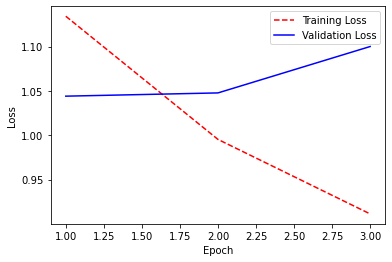

60427


In [21]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

y_pred=model.predict_classes(X_test)

print(len(y_pred))

In [22]:
sub_file = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')
print(sub_file.shape)
sub_file = sub_file[['review_id']]
sub_file['rating']= y_pred
sub_file['rating'] = sub_file['rating'] + 1
sub_file.to_csv('Submission.csv',index=False)

(60427, 2)
